## Creating new files that only contain relevant data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Loading AQI calculation functions.

In [2]:
from calculations import *

Read the csv file exported from the BigQuery data. This file contains all entries from the 'air_quality_annual_summary' table where parameter_code matches the list of parameters we are interested in. 

In [2]:
annual = pd.read_csv('air_quality_annual_summary.csv')

/Users/pear/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
annual.columns

Index([u'state_code', u'county_code', u'site_num', u'parameter_code', u'poc',
       u'latitude', u'longitude', u'datum', u'parameter_name',
       u'sample_duration', u'pollutant_standard', u'metric_used',
       u'method_name', u'year', u'units_of_measure', u'event_type',
       u'observation_count', u'observation_percent', u'completeness_indicator',
       u'valid_day_count', u'required_day_count', u'exceptional_data_count',
       u'null_data_count', u'primary_exceedance_count',
       u'secondary_exceedance_count', u'certification_indicator',
       u'num_obs_below_mdl', u'arithmetic_mean', u'arithmetic_standard_dev',
       u'first_max_value', u'first_max_datetime', u'second_max_value',
       u'second_max_datetime', u'third_max_value', u'third_max_datetime',
       u'fourth_max_value', u'fourth_max_datetime',
       u'first_max_non_overlapping_value', u'first_no_max_datetime',
       u'second_max_non_overlapping_value', u'second_no_max_datetime',
       u'ninety_nine_percentile'

List the parameters in this dataframe.

In [28]:
annual['parameter_name'].unique()

array(['Ozone', 'Lead PM2.5 LC', 'Sulfur dioxide', 'Carbon monoxide',
       'Outdoor Temperature', 'PM10 Total 0-10um STP',
       'Nitrogen dioxide (NO2)', 'PM2.5 - Local Conditions'], dtype=object)

### Creating a new table with top 20 cities

In [3]:
column_list = ['site_num','parameter_code','parameter_name','sample_duration','pollutant_standard',
              'metric_used','method_name','year','units_of_measure','event_type','observation_count',
              'arithmetic_mean','first_max_value','ninety_percentile','ten_percentile','state_name',
              'city_name']

In [3]:
city_list = ['New York','Los Angeles','Chicago','Houston','Phoenix','Philadelphia',
            'San Antonio','San Diego','Dallas','San Jose','Austin','Jacksonville',
            'San Francisco','Columbus','Indianapolis','Fort Worth','Charlotte','Seattle',
            'Seattle','Denver','El Paso']

In [31]:
top_city_annual = annual[column_list][annual['city_name'].isin(city_list)]

In [32]:
len(top_city_annual)

28054

In [5]:
#Keeping track of memory usage
import os, psutil
def usage():
    process = psutil.Process(os.getpid())
    return process.memory_info()[0] / float(2 ** 20)

In [6]:
usage()

66.2421875

In [46]:
#saving the intermediate table so we can free up some memory
top_city_annual.to_csv('top_city_annual.csv')

In [33]:
#reading the file
top_city_annual = pd.read_csv('top_city_annual.csv')

In [58]:
top_city_annual[(top_city_annual['city_name']=='Chicago')&(top_city_annual['year']==2012)&
               (top_city_annual['parameter_name'].str.contains('Sulfur'))]

,Unnamed: 0,site_num,parameter_code,parameter_name,sample_duration,pollutant_standard,metric_used,method_name,year,units_of_measure,event_type,observation_count,arithmetic_mean,first_max_value,ninety_percentile,ten_percentile,state_name,city_name
6982,102814,76,42401,Sulfur dioxide,3-HR BLK AVG,SO2 3-hour 1971,3-Hour block average of observed hourly values,NaN,2012,Parts per billion,No Events,2657,1.777418,15.3,4.0,0.0,Illinois,Chicago
19686,291479,76,42401,Sulfur dioxide,1 HOUR,SO2 1-hour 2010,Daily maximum 1-hour average,INSTRUMENTAL - ULTRA VIOLET FLUORESCENCE,2012,Parts per billion,No Events,8040,4.041667,18.0,8.0,1.0,Illinois,Chicago
21423,317387,76,42401,Sulfur dioxide,1 HOUR,SO2 Annual 1971,Observed Values,INSTRUMENTAL - ULTRA VIOLET FLUORESCENCE,2012,Parts per billion,No Events,8040,1.794652,18.0,4.0,0.0,Illinois,Chicago
27616,406566,76,42401,Sulfur dioxide,24-HR BLK AVG,SO2 24-hour 1971,Daily Average of observed values,NaN,2012,Parts per billion,No Events,336,1.793155,9.4,3.5,0.3,Illinois,Chicago


In [34]:
pollutant_codes={'Ozone':44201,'PM25':88101,'PM10':81102,'CO':42101,'SO2':42401,'NO2':42602,'Temp':62101,'Lead':88128}

def get_pollutant_value(df_full,code):
    #extract entries for this pollutant
    df = df_full[df_full['parameter_code']==code]
    if df.empty:
        return np.NAN
    elif code == pollutant_codes['Ozone']:
        try: 
            value = max(df['arithmetic_mean'][(df['pollutant_standard']=='Ozone 8-hour 2015')&
                                          (df['event_type']=='Events Excluded')].values)
        except:
            value = max(df['arithmetic_mean'][(df['sample_duration'].str.contains('8'))])
    elif code == pollutant_codes['PM25']:
        try:
            value = max(df['arithmetic_mean'][(df['pollutant_standard']=='PM25 24-hour 2006')])
        except:
            value = max(df['arithmetic_mean'])
    elif code == pollutant_codes['PM10']:
        try:
            value = max(df['arithmetic_mean'][(df['pollutant_standard']=='PM10 24-hour 2006')])
        except:
            value = max(df['arithmetic_mean'])
    elif code == pollutant_codes['CO']:
        try:
            value = max(df['arithmetic_mean'][(df['pollutant_standard']=='CO 8-hour 1971')])
        except:
            value = max(df['arithmetic_mean'][(df['sample_duration'].str.contains('8'))])
    elif code == pollutant_codes['SO2']:
        try:
            value = max(df['arithmetic_mean'][(df['pollutant_standard']=='SO2 1-hour 1971')])
        except:
            value = max(df['arithmetic_mean'][(df['sample_duration'].str.contains('1'))])
    elif code == pollutant_codes['NO2']:
        try:
            value = max(df['arithmetic_mean'][(df['pollutant_standard']=='NO2 1-hour')])
        except:
            value = max(df['arithmetic_mean'][(df['sample_duration'].str.contains('1'))])
    return value
        

In [6]:
def get_aqi_city_year(df):
    #input: df = dataframe for a specific city and year
    Ozone = get_pollutant_value(df,pollutant_codes['Ozone'])
    PM25 = get_pollutant_value(df,pollutant_codes['PM25'])
    PM10 = get_pollutant_value(df,pollutant_codes['PM10'])
    CO = get_pollutant_value(df,pollutant_codes['CO'])
    SO2 = get_pollutant_value(df,pollutant_codes['SO2'])
    NO2 = get_pollutant_value(df,pollutant_codes['NO2'])
    aqi_list = calculate_aqi([Ozone,PM25,PM10,CO,SO2,NO2])
    return aqi_list


In [35]:
def get_aqi(df_full,city,year):
    df = df_full[(df_full['city_name']==city)&(df_full['year']==year)]
    aqi_list = get_aqi_city_year(df)
    return aqi_list

In [36]:
#testing
aqi_list = get_aqi(top_city_annual,'Austin',2015)
aqi_list

[38, 39, 21, nan, 0, 24]

#### Creating a new table for AQI

In [37]:
groups = top_city_annual.groupby(['city_name','year'])

In [38]:
city_aqi = pd.DataFrame(groups.groups.keys(),columns=['city_name','year'])

In [39]:
city_aqi.head()

,city_name,year
0,San Francisco,1995
1,Jacksonville,2008
2,Indianapolis,2016
3,Jacksonville,2016
4,Fort Worth,2007


In [41]:
aqi_series = city_aqi.apply(lambda df: get_aqi(top_city_annual,df['city_name'],df['year']),axis=1)

In [43]:
aqi_series.head()

0        [24, nan, 22, 13, 5, 32]
1          [40, 37, 22, 4, 5, 19]
2    [nan, nan, nan, 6, nan, nan]
3          [37, 38, 16, 5, 2, 19]
4       [44, 48, nan, 3, nan, 29]
dtype: object

In [44]:
aqi_df = pd.DataFrame(aqi_series.tolist(),columns=['Ozone','PM2.5','PM10','Carbon monoxide',
                                                   'Sulfur dioxide','Nitrogen dioxide'])

In [45]:
aqi_df.head()

,Ozone,PM2.5,PM10,Carbon monoxide,Sulfur dioxide,Nitrogen dioxide
0,24.0,NaN,22.0,13.0,5.0,32.0
1,40.0,37.0,22.0,4.0,5.0,19.0
2,NaN,NaN,NaN,6.0,NaN,NaN
3,37.0,38.0,16.0,5.0,2.0,19.0
4,44.0,48.0,NaN,3.0,NaN,29.0


In [46]:
city_aqi = pd.concat([city_aqi,aqi_df],axis=1)

In [78]:
city_aqi.to_csv('city_aqi.csv')

In [49]:
city_aqi.head(10)

,city_name,year,Ozone,PM2.5,PM10,Carbon monoxide,Sulfur dioxide,Nitrogen dioxide
0,San Francisco,1995,24.0,NaN,22.0,13.0,5.0,32.0
1,Jacksonville,2008,40.0,37.0,22.0,4.0,5.0,19.0
2,Indianapolis,2016,NaN,NaN,NaN,6.0,NaN,NaN
3,Jacksonville,2016,37.0,38.0,16.0,5.0,2.0,19.0
4,Fort Worth,2007,44.0,48.0,NaN,3.0,NaN,29.0
5,Denver,1999,40.0,37.0,29.0,13.0,24.0,52.0
6,Indianapolis,1990,43.0,NaN,37.0,15.0,51.0,28.0
7,Philadelphia,2003,42.0,59.0,27.0,10.0,20.0,35.0
8,Columbus,2011,39.0,49.0,21.0,2.0,NaN,NaN
9,Houston,2010,37.0,51.0,32.0,2.0,8.0,28.0


In [54]:
austin = city_aqi[city_aqi['city_name']=='Austin'].sort_values('year')

In [67]:
def plot_city(city):
    city = city_aqi[city_aqi['city_name']==city].sort_values('year')
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    ax.plot(city['year'],city['Ozone'],'bo-',label='Ozone')
    ax.plot(city['year'],city['Carbon monoxide'],'ro-',label='CO')
    ax.plot(city['year'],city['PM10'],'go-',label='PM10')
    ax.plot(city['year'],city['PM2.5'],'yo-',label='PM2.5')
    ax.legend()
    plt.show()

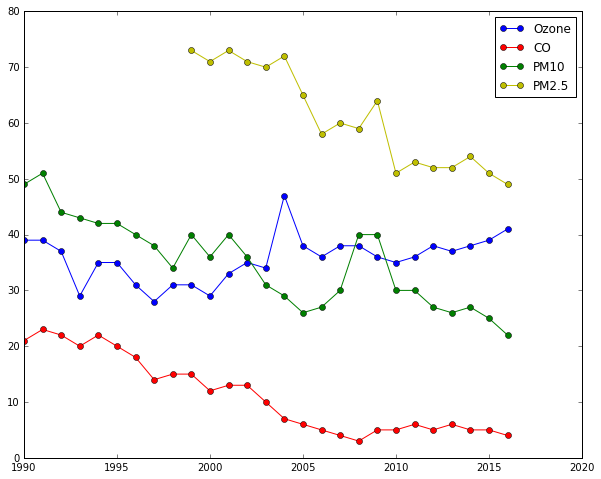

In [68]:
plot_city('Los Angeles')

### Looking at 2016 Data

In [3]:
data2016 = annual[annual['year']==2016]

In [87]:
data2016.shape

(18079, 55)

In [11]:
data2016['parameter_name'].value_counts()

PM2.5 - Local Conditions    6371
Ozone                       5482
Sulfur dioxide              2149
PM10 Total 0-10um STP       1501
Nitrogen dioxide (NO2)       930
Outdoor Temperature          853
Carbon monoxide              638
Lead PM2.5 LC                155
Name: parameter_name, dtype: int64

#### Adding station data

In [4]:
stations = pd.read_csv('aqs_sites.csv')
columns_list = ['State Code','County Code','Site Number','Elevation','Land Use','Location Setting','Local Site Name']

In [30]:
stations.columns

Index([u'State Code', u'County Code', u'Site Number', u'Latitude',
       u'Longitude', u'Datum', u'Elevation', u'Land Use', u'Location Setting',
       u'Site Established Date', u'Site Closed Date', u'Met Site State Code',
       u'Met Site County Code', u'Met Site Site Number', u'Met Site Type',
       u'Met Site Distance', u'Met Site Direction', u'GMT Offset',
       u'Owning Agency', u'Local Site Name', u'Address', u'Zip Code',
       u'State Name', u'County Name', u'City Name', u'CBSA Name',
       u'Tribe Name', u'Extraction Date'],
      dtype='object')

Clean up data before merging

In [5]:
#State code columns have mixed types data. Need to convert them to int

def stringToNum(x):
    try:
        x = x.lstrip('0')
        x = int(x)
    except:
        pass
    return x

stations.loc[:,'State Code'] = stations['State Code'].map(stringToNum)
data2016.loc[:,'state_code'] = data2016['state_code'].map(stringToNum)

/Users/pear/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
data2016 = pd.merge(data2016,stations[columns_list],how='left',
                    left_on=['state_code','county_code','site_num'],
                    right_on=['State Code','County Code','Site Number'])

In [7]:
data2016.shape

(18079, 62)

In [8]:
#write to file 
data2016.to_csv('annual_aqs_2016.csv')

In [2]:
data2016 = pd.read_csv('annual_aqs_2016.csv', index_col=0)

Looking at mean by location types

Removing duplicates.
We are selecting the row by first only keep events type 'excluded'. Then select the row with the maximum mean.

In [65]:
#Removing duplicates so we only have one row for each site + pollutant

data2016_nodup = data2016[(~data2016['event_type'].str.contains('Incl'))] \
    .sort_values(by='arithmetic_mean',ascending=False).drop_duplicates(subset=[
    'state_code','county_code','site_num','parameter_name'])

In [66]:
#Checking that we only have one row per each
data2016_nodup.groupby(by=['state_code','county_code','site_num','parameter_name'])['arithmetic_mean'] \
    .agg('count').value_counts()

1    5055
Name: arithmetic_mean, dtype: int64

In [67]:
#Double checking that we don't have any entries of 'events included' types
data2016_nodup['event_type'].value_counts()

No Events                    4861
Concurred Events Excluded     192
Events Excluded                 2
Name: event_type, dtype: int64

Now we can look at average by land types. The columns we are interested in is 'Land Use' and 'Location Setting'.

In [72]:
data2016_nodup.groupby(by=['parameter_name','Land Use'])['arithmetic_mean'].agg(['mean','std'])

mean        std
parameter_name           Land Use                                  
Carbon monoxide          AGRICULTURAL           0.182740   0.074183
                         BLIGHTED AREAS         0.324109   0.232812
                         COMMERCIAL             0.313679   0.149334
                         FOREST                 0.165924   0.047014
                         INDUSTRIAL             0.382988   0.420772
                         MILITARY RESERVATION   0.164680        NaN
                         MOBILE                 0.377744   0.206180
                         RESIDENTIAL            0.299893   0.135705
Lead PM2.5 LC            AGRICULTURAL           0.005363   0.001392
                         BLIGHTED AREAS         0.010222        NaN
                         COMMERCIAL             0.007255   0.005318
                         FOREST                 0.005101   0.001280
                         INDUSTRIAL             0.006461   0.002391
                         MOBILE                 0.004334   0.003300
                         RESIDENTIAL            0.005764   0.004143
Nitrogen dioxide (NO2)   AGRICULTURAL           7.293459   6.053452
                         BLIGHTED AREAS        25.697850  15.435070
                         COMMERCIAL            20.561797   8.710860
                         DESERT                 6.934877   4.656539
                         FOREST                 5.454336   4.372524
                         INDUSTRIAL            16.742238  10.992730
                         MILITARY RESERVATION  13.041065   7.916369
                         MOBILE                24.168347   8.021467
                         RESIDENTIAL           17.924260   8.325888
                         UNKNOWN               13.609890        NaN
Outdoor Temperature      AGRICULTURAL          57.185289   8.583413
                         BLIGHTED AREAS        53.685713   5.659640
                         COMMERCIAL            61.127187  10.174457
                         DESERT                62.989945  10.659806
                         FOREST                53.024366   8.902814
...                                                  ...        ...
Ozone                    RESIDENTIAL            0.048417   0.006345
                         UNKNOWN                0.049474        NaN
PM10 Total 0-10um STP    AGRICULTURAL          22.208506  16.145670
                         BLIGHTED AREAS        25.276596        NaN
                         COMMERCIAL            19.834654   7.734901
                         DESERT                18.768884  12.708066
                         FOREST                11.717149   6.522771
                         INDUSTRIAL            18.857423   9.219051
                         MILITARY RESERVATION  14.708096   3.137763
                         MOBILE                18.510069   7.399819
                         RESIDENTIAL           19.634630   8.275231
PM2.5 - Local Conditions AGRICULTURAL           7.005366   2.247448
                         BLIGHTED AREAS         7.874708   0.559301
                         COMMERCIAL             7.763655   1.919206
                         DESERT                 3.652440   2.693787
                         FOREST                 5.725599   2.034830
                         INDUSTRIAL             8.238252   1.997268
                         MILITARY RESERVATION   7.159762   1.045388
                         MOBILE                 7.783706   3.039160
                         RESIDENTIAL            7.618944   2.020206
Sulfur dioxide           AGRICULTURAL           1.760847   1.579860
                         BLIGHTED AREAS         0.871287        NaN
                         COMMERCIAL             2.499824   2.858166
                         DESERT                 3.138288   2.186671
                         FOREST                 6.758218  25.489803
                         INDUSTRIAL             4.994341   8.806096
                         MILITARY RESERV